In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, ConcatDataset, Subset
# from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

from PIL import Image

# disable warnings
Image.MAX_IMAGE_PIXELS = None # image processing
# auto-reload functions before each instance running them
%load_ext autoreload
%autoreload 2

In [2]:
# Remote instance set-up cell
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cpu


In [3]:
# directory setup cell
repo = 'tree-finder/'
location = 'local'
save_mode = True

# Local paths
local_root = '/Users/etriesch/dev/'
colab_root = '/content/drive/My Drive/git/'
aws_root = '/home/ec2-user/'

# define root
if location == 'local':
  root = local_root
elif location == 'google':
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  root = colab_root
elif location == 'aws':
  root = aws_root

repo_path = root + repo
model_path = repo_path + 'models/'
data_path = repo_path + 'data/'
results_path = repo_path + 'results/'
sys.path.append(repo_path)

In [4]:
# setup cell
from notebooks.viz_fns import show_image_batch, set_plt_settings, create_class_vis
# from notebooks.plot_fns import plot_accs
# from notebooks.train_fns import Flatten, train_model
from notebooks.data_processing import define_transforms, make_dataloaders, IMAGE_DIM, MEAN, STD
from notebooks.models import ResnetTransferClassifier, ConvnextTransferClassifier, TransformerTransferClassifier
# from notebooks.scrape_fns import get_filelist

set_plt_settings()

# Make dataset and loaders
This includes augmenting my dataset

In [5]:
# define transformations
transforms = define_transforms(scale_up=1024, crop=1024, scale_out=IMAGE_DIM, mean=MEAN, std=STD, mirror=True, randomcrop=[10,25,50])
# create dataset by concatenating all transformations
treeds = []
for t in transforms:
    df = dset.ImageFolder(root=data_path + 'images_spec', transform=transforms[t])
    treeds.append(df)

treeds = ConcatDataset(treeds)
class_names = treeds.datasets[0].classes

In [6]:
# load image scores
filename = 'images_spec_realtree_pcts.csv'
realtree_likelihood = np.loadtxt(data_path + filename).astype(float).tolist()

# subset based on threshold
threshold=0.85
flag = np.array(realtree_likelihood) > threshold
realtree_idxs = (np.arange(0, len(flag))[flag]).tolist()
print(f'\nimages meeting threshold ({threshold}): {sum(flag)} ({sum(flag)/len(flag):0.2%})')
# realtree_idxs = None

# make dataloaders with the subset data
dataloaders, ds_sizes = make_dataloaders(
    dataset=treeds, subset=realtree_idxs, test_split=0.10, val_split=0.25, 
    sampleN=4, batch_size=32, seed=1)


images meeting threshold (0.85): 24944 (75.97%)
dataloader sizes: {'all': 24944, 'train': 16836, 'validate': 5613, 'test': 2495, 'sampler': 4}


# Load final model

In [8]:
# load final model and final model weights
final_model = ConvnextTransferClassifier(num_classes=7, retrain_last_cnblock=False).to(device)
final_model_wts = torch.load(model_path + 'ConvNextClassifierFC.pt', map_location=torch.device('cpu'))
final_model.load_state_dict(final_model_wts)

<All keys matched successfully>

# Assess final model

In [9]:
# define small loader for testing
random_idxs = np.array(realtree_idxs)[np.random.choice(range(len(realtree_idxs)), 500)]
small_loaders, small_ds_sizes = make_dataloaders(
    dataset=treeds, subset=random_idxs, test_split=0.10, val_split=0.25, 
    sampleN=4, batch_size=10, seed=15)

# setup testing parameters
loaders = small_loaders
sizes = small_ds_sizes
# loaders = dataloaders
# sizes = ds_sizes

dataloader sizes: {'all': 500, 'train': 337, 'validate': 113, 'test': 50, 'sampler': 4}


In [10]:
# make predictions on test set for final model
images = torch.Tensor()
classes = torch.Tensor()
class_scores = torch.Tensor()

for X, y in tqdm(loaders['test']):
  X, y = X.to(device=device), y.to(device=device)
  out = final_model(X)
  images = torch.cat((images, X))
  classes = torch.cat((classes, y))
  class_scores = torch.cat((class_scores, out))

100%|██████████| 5/5 [00:31<00:00,  6.40s/it]


### Top1 and Top2 accuracy

In [11]:
# calculate top1 and top2 accuracy
N_test = sizes['test']
true_class = classes.int()
true_class_scores = class_scores[range(N_test), classes.numpy()]

max_classes = torch.argsort(class_scores, dim=-1, descending=True)
pred_class = max_classes[:, 0:1].squeeze(dim=-1)
pred_class_scores = class_scores[range(N_test), pred_class]

N_acc_1 = torch.sum((pred_class == classes)).item()
N_acc_2 = torch.sum((max_classes[:, 0:2] == classes.unsqueeze(dim=-1)).any(dim=-1)).item()
print('top-1 accuracy:', N_acc_1 / N_test)
print('top-2 accuracy:', N_acc_2 / N_test)

top-1 accuracy: 0.6
top-2 accuracy: 0.66


### Confusion matrix

In [24]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(true_class, pred_class, normalize='true')

df_cm = pd.DataFrame(cf_matrix, index = [i for i in class_names],
                     columns = [i for i in class_names]).round(2)
abbrevs = ['BL', 'BW', 'C', 'HL', 'LP', 'O', 'P']
df_cm.columns = abbrevs
df_cm.index = abbrevs
print(df_cm.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &    BL &    BW &     C &    HL &    LP &     O &     P \\
\midrule
BL &  0.71 &  0.14 &  0.00 &  0.14 &  0.00 &  0.00 &  0.00 \\
BW &  0.25 &  0.62 &  0.00 &  0.00 &  0.12 &  0.00 &  0.00 \\
C  &  0.00 &  0.29 &  0.57 &  0.00 &  0.14 &  0.00 &  0.00 \\
HL &  0.17 &  0.33 &  0.00 &  0.33 &  0.00 &  0.00 &  0.17 \\
LP &  0.00 &  0.14 &  0.00 &  0.00 &  0.86 &  0.00 &  0.00 \\
O  &  0.14 &  0.00 &  0.14 &  0.14 &  0.00 &  0.57 &  0.00 \\
P  &  0.12 &  0.00 &  0.25 &  0.00 &  0.00 &  0.12 &  0.50 \\
\bottomrule
\end{tabular}



/var/folders/mw/dy3m3wg11js6x91fwng5ptdw0000gn/T/ipykernel_6611/2277623921.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_cm.to_latex())


### Precision and recall

In [29]:
# precision and recall summary
from sklearn.metrics import classification_report
precall = classification_report(y_true=true_class, y_pred=pred_class, output_dict=True)
precall = pd.DataFrame(precall).T.round(3).drop(['accuracy', 'macro avg'])
precall.index = abbrevs + ['weighted avg']
print(precall.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
BL           &      0.500 &   0.714 &     0.588 &      7.0 \\
BW           &      0.455 &   0.625 &     0.526 &      8.0 \\
C            &      0.571 &   0.571 &     0.571 &      7.0 \\
HL           &      0.500 &   0.333 &     0.400 &      6.0 \\
LP           &      0.750 &   0.857 &     0.800 &      7.0 \\
O            &      0.800 &   0.571 &     0.667 &      7.0 \\
P            &      0.800 &   0.500 &     0.615 &      8.0 \\
weighted avg &      0.628 &   0.600 &     0.598 &     50.0 \\
\bottomrule
\end{tabular}



/var/folders/mw/dy3m3wg11js6x91fwng5ptdw0000gn/T/ipykernel_6611/3538973967.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(precall.to_latex())


### Top and bottom N images

image saved to file: /Users/etriesch/dev/tree-finder/results/fig_top_img.png


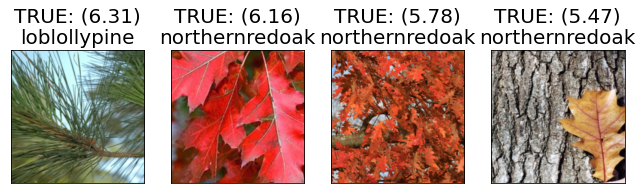

In [41]:
# print N top images
num_images = 4
# get highest scoring images
top_image_idxs = torch.argsort(true_class_scores, descending=True)[0:num_images]
top_true_class = true_class[top_image_idxs]
top_true_scores = true_class_scores[top_image_idxs]
top_images = images[top_image_idxs]

show_image_batch(top_images.cpu(), MEAN, STD, 
title=[f'TRUE: ({l:0.2f})\n{class_names[x]}' for x,l in zip(top_true_class, top_true_scores)],
figdim=11, savetofile=results_path + 'fig_top_img.png')

image saved to file: /Users/etriesch/dev/tree-finder/results/fig_bott_img.png


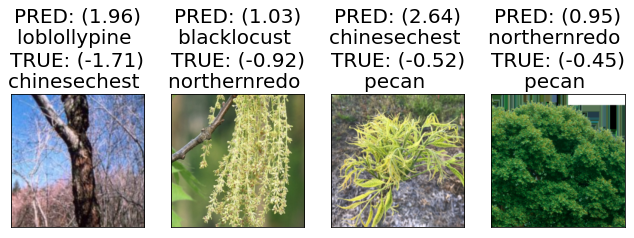

In [40]:
# print N bottom images
# get highest scoring images
bott_image_idxs = torch.argsort(true_class_scores, descending=False)[0:num_images]
bott_true_class = true_class[bott_image_idxs]
bott_true_scores = true_class_scores[bott_image_idxs]
bott_pred_class = pred_class[bott_image_idxs]
bott_pred_scores = pred_class_scores[bott_image_idxs]
bott_images = images[bott_image_idxs]

show_image_batch(
    bott_images.cpu(), MEAN, STD, 
    title=[f'PRED: ({s_p:0.2f})\n{class_names[x_p][:12]} \nTRUE: ({s_t:0.2f})\n{class_names[x_t][:12]} ' 
           for x_t, s_t, x_p, s_p in zip(bott_true_class, bott_true_scores, bott_pred_class, bott_pred_scores)],
           figdim=11, savetofile=results_path + 'fig_bott_img.png'
    )

### Visualize classes with gradient ascent

In [42]:
dtype = torch.FloatTensor
class_vis = torch.Tensor()
for c in tqdm(range(len(class_names))):
  cv = create_class_vis(target_y=c, model=final_model, class_names=class_names, dtype=dtype, num_iterations=10)
  class_vis = torch.concat((class_vis, cv.unsqueeze(0)))

100%|██████████| 7/7 [00:23<00:00,  3.37s/it]


image saved to file: /Users/etriesch/dev/tree-finder/results/fig_class_vis.png


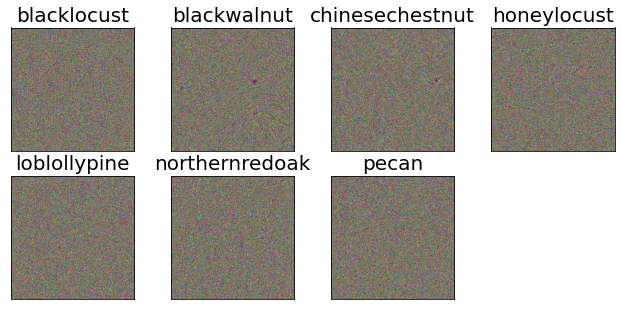

In [45]:
show_image_batch(class_vis.cpu(), title=[x for x in class_names], 
figdim=11, savetofile=results_path + 'fig_class_vis.png'
)

In [ ]:
# git saver cell
# git saver
%cd '/content/drive/My Drive /git/tree-finder'
!git config --global user.email "erich.j.trieschman@gmail.com"
!git config --global user.name "Erich Trieschman"

/content/drive/My Drive /git/tree-finder


In [ ]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   notebooks/evaluate_final_model.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
!git add .
!git commit -m 'upload AWS trained model results and final model eval'
!git push

[main 4be44b2] upload AWS trained model results and final model eval
 13 files changed, 269 insertions(+), 56 deletions(-)
 create mode 100644 notebooks/__pycache__/viz_fns.cpython-37.pyc
 create mode 100644 notebooks/evaluate_final_model.ipynb
 delete mode 100644 notebooks/plot_fns.py
 rewrite notebooks/preprocess_images.ipynb (75%)
 rewrite notebooks/train_binary_tree_classifier.ipynb (81%)
 rewrite notebooks/train_species_classifiers.ipynb (89%)
 create mode 100644 notebooks/viz_fns.py
 create mode 100644 results/acc_ResnetBinClassifier.csv
Counting objects: 17, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (17/17), done.
Writing objects: 100% (17/17), 2.66 MiB | 6.43 MiB/s, done.
Total 17 (delta 9), reused 0 (delta 0)
remote: Resolving deltas: 100% (9/9), completed with 9 local objects.
To https://github.com/etrieschman/tree-finder
   28435b5..4be44b2  main -> main
